In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy import stats
import lightgbm as lgb

import optuna
from optuna.visualization import (
    plot_contour
    , plot_edf
    , plot_intermediate_values
    , plot_optimization_history
    , plot_parallel_coordinate
    , plot_param_importances
    , plot_slice
)

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.io as pio

pio.renderers.default = "jupyterlab"

***
## loading data

In [2]:
features = [f"f_{i}" for i in range(300)]

features = pd.read_parquet("../ump-dataset/train.parquet", columns=features)
target = pd.read_parquet("../ump-dataset/train.parquet", columns=["target",])
time = pd.read_parquet("../ump-dataset/train.parquet", columns=["time_id",])

In [3]:
time_ids = np.sort(time.time_id.unique())
len(time_ids)

1211

In [4]:
n_time_steps = len(time_ids)
print("time steps:", n_time_steps)

valid_prop = 0.3
valid_size = int(valid_prop * n_time_steps)
print("valid size:", valid_size)

time steps: 1211
valid size: 363


In [5]:
valid_time_ids = time_ids[-valid_size:]

In [6]:
train_idx = time.query("time_id not in @valid_time_ids").index
valid_idx = time.query("time_id in @valid_time_ids").index

# dataframes for metric calculation
oof = target.loc[valid_idx,:].copy()
oof["time_id"] = time.loc[valid_idx,"time_id"]
features_valid = features.loc[valid_idx,:]

# input dataset for lgbm
train_dset = lgb.Dataset(
    data=features.loc[train_idx,:],
    label=target.loc[train_idx,"target"].values,
    free_raw_data=True
)
valid_dset = lgb.Dataset(
    data=features.loc[valid_idx,:],
    label=target.loc[valid_idx,"target"].values,
    free_raw_data=True
)

In [7]:
import gc
gc.collect()

44

***
## Bayesian Optimization

In [8]:
default_params = {
    'linear_tree':True,
    'objective': 'mse',
    'metric': 'rmse',
    'learning_rate': 0.05,
    'force_col_wise': True,
    'bagging_freq': 1,
    'seed': 19,
    'verbosity': -1,
    'first_metric_only': False,
    'bin_construct_sample_cnt': int(1e8),
    'feature_pre_filter' : False,
}

In [9]:
def pearsonr(preds: np.array, dset: lgb.Dataset):
    """
    Helper function to compute Pearson correlation 
    on validation dataset for LightGBM as tracking metric.
    Args:
        preds: 1d-array with the model predictions
        dset: LightGBM dataset with the labels
    Returs:
        Tuple with the corresponding output
    """
    labels = dset.get_label()
    return 'pearsonr', stats.pearsonr(preds, labels)[0], True

In [10]:
def objective(trial):    
    sampled_params = dict(
        num_leaves = 2 ** trial.suggest_int("num_leaves_exp", 5, 7),
        max_bin = 2 ** trial.suggest_int("max_bin_exp", 6, 10) - 1,
        feature_fraction = trial.suggest_discrete_uniform("feature_fraction", 0.1, 0.5, 0.05),
        bagging_fraction = trial.suggest_discrete_uniform("bagging_fraction", 0.8, 1.0, 0.05),
        lambda_l1 = trial.suggest_loguniform("lambda_l1", 1e-4, 1e1),
        lambda_l2 = trial.suggest_loguniform("lambda_l2", 1e-4, 1e1),
        linear_lambda = trial.suggest_float("linear_lambda", 0., 100.),
        path_smooth = trial.suggest_float("path_smooth", 0., 50.),
        min_data_in_leaf = trial.suggest_int("min_data_in_leaf", 500, 5000, 100),
    )
    model_params = {**default_params, **sampled_params}
        
    model = lgb.train(
        params=model_params,
        train_set=train_dset,
        num_boost_round=trial.suggest_int("num_iterations", 500, 2000, 100),
    )
    
    # metric calculation
    _oof = oof.copy()
    _oof["pred"] = model.predict(features_valid)
    corrs = _oof.groupby("time_id").apply(lambda x: stats.pearsonr(x.target, x.pred)[0])
    corr_mean = corrs.mean()
    corr_std = corrs.std()
    
    return corr_mean            

In [11]:
do_optimize = False

study = optuna.create_study(
    study_name="lgbm-linear",
    direction='maximize',
    storage='sqlite:///lgbm-linear.db',
    load_if_exists=True,
)

if do_optimize:
    study.optimize(
        objective, 
        n_trials=1000, 
        timeout=43200, # 12-hrs
        n_jobs=1, 
        gc_after_trial=True,
    ) 

[I 2022-03-12 21:55:35,834] Using an existing study with name 'lgbm-linear' instead of creating a new one.


In [12]:
study.trials_dataframe().sort_values("value", ascending=False).head(20)

,number,value,datetime_start,datetime_complete,duration,params_bagging_fraction,params_feature_fraction,params_lambda_l1,params_lambda_l2,params_linear_lambda,params_max_bin_exp,params_min_data_in_leaf,params_num_iterations,params_num_leaves_exp,params_path_smooth,state
490,490,0.133679,2022-03-12 11:10:57.592597,2022-03-12 11:15:00.412566,0 days 00:04:02.819969,1.0,0.20,0.009586,0.001157,90.068520,9,3700,1300,5,5.539030,COMPLETE
403,403,0.133650,2022-03-12 04:48:09.948428,2022-03-12 04:52:12.373368,0 days 00:04:02.424940,1.0,0.20,0.044620,0.001172,68.207924,9,3600,1300,5,30.457112,COMPLETE
425,425,0.133634,2022-03-12 06:23:03.701729,2022-03-12 06:27:17.744294,0 days 00:04:14.042565,1.0,0.20,0.073972,0.001115,75.289486,9,3600,1400,5,29.191407,COMPLETE
135,135,0.133592,2022-03-11 10:38:47.499429,2022-03-11 10:42:53.534322,0 days 00:04:06.034893,1.0,0.20,0.014246,0.005688,64.840123,9,2500,1400,5,39.712651,COMPLETE
74,74,0.133583,2022-03-11 06:34:03.509239,2022-03-11 06:37:56.960432,0 days 00:03:53.451193,1.0,0.15,0.116373,0.201590,66.573278,10,3000,1400,5,29.360672,COMPLETE
48,48,0.133536,2022-03-11 04:24:09.581835,2022-03-11 04:28:26.016348,0 days 00:04:16.434513,1.0,0.20,8.415136,0.078876,83.631288,9,3700,1400,5,40.788646,COMPLETE
446,446,0.133504,2022-03-12 07:58:45.346971,2022-03-12 08:02:43.189659,0 days 00:03:57.842688,1.0,0.20,0.042541,0.002167,85.871303,9,3100,1300,5,27.726472,COMPLETE
208,208,0.133498,2022-03-11 15:47:52.348239,2022-03-11 15:52:01.204353,0 days 00:04:08.856114,1.0,0.20,0.005900,0.044197,73.623402,9,2600,1400,5,42.023955,COMPLETE
401,401,0.133494,2022-03-12 04:40:14.577871,2022-03-12 04:44:15.280118,0 days 00:04:00.702247,1.0,0.20,0.052293,0.000962,71.042219,9,3500,1300,5,31.767034,COMPLETE
233,233,0.133472,2022-03-11 17:25:12.556170,2022-03-11 17:29:12.147098,0 days 00:03:59.590928,1.0,0.20,0.021951,0.004711,79.404073,9,3200,1300,5,25.975439,COMPLETE


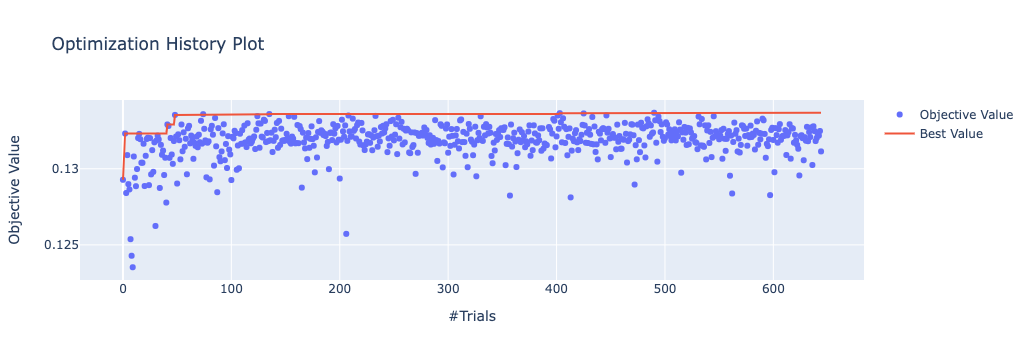

In [13]:
plot_optimization_history(study)

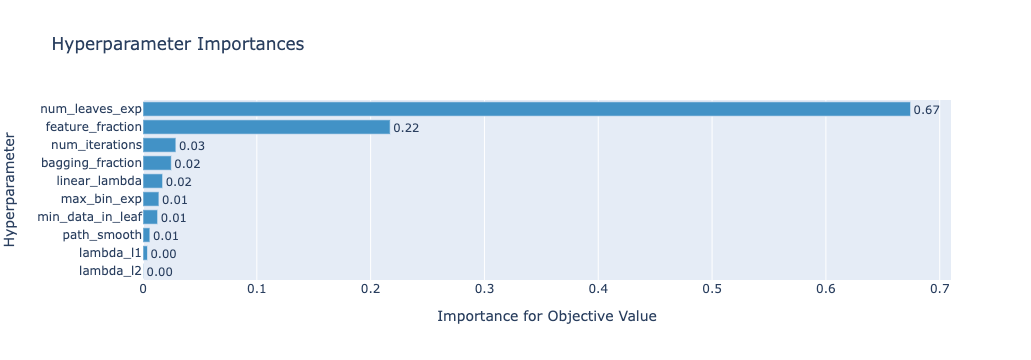

In [14]:
plot_param_importances(study)

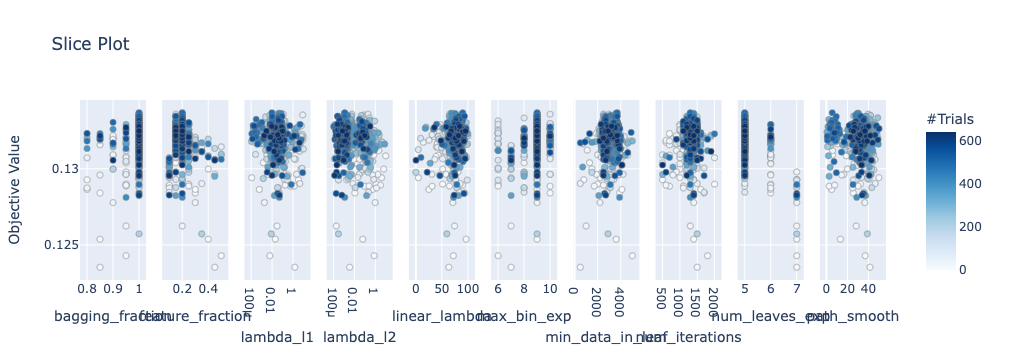

In [15]:
plot_slice(study)

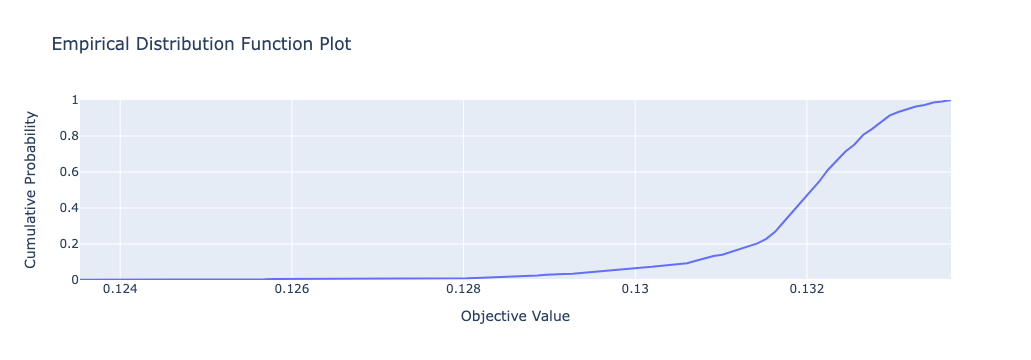

In [16]:
plot_edf(study)

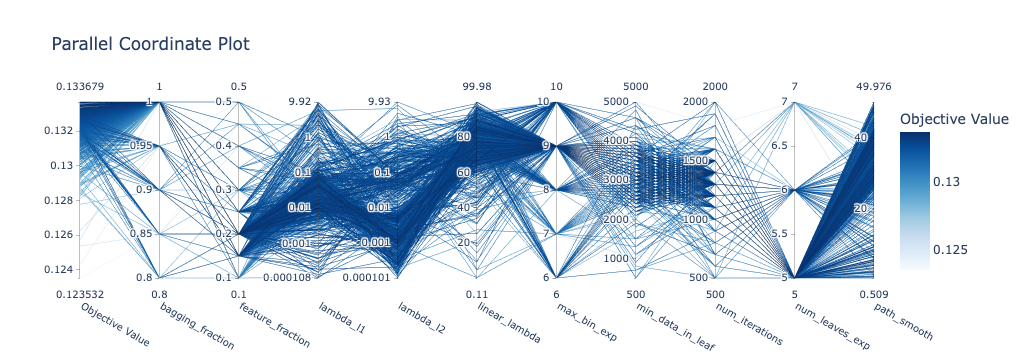

In [17]:
plot_parallel_coordinate(study)

In [18]:
best_params = dict(study.best_params)
best_params["num_leaves"] = 2**best_params.pop("num_leaves_exp")
best_params["max_bin"] = 2**best_params.pop("max_bin_exp")-1
best_params = {**default_params, **best_params}
best_params

{'linear_tree': True,
 'objective': 'mse',
 'metric': 'rmse',
 'learning_rate': 0.05,
 'force_col_wise': True,
 'bagging_freq': 1,
 'seed': 19,
 'verbosity': -1,
 'first_metric_only': False,
 'bin_construct_sample_cnt': 100000000,
 'feature_pre_filter': False,
 'bagging_fraction': 1.0,
 'feature_fraction': 0.2,
 'lambda_l1': 0.009585746811293492,
 'lambda_l2': 0.0011570471036776511,
 'linear_lambda': 90.06851987063091,
 'min_data_in_leaf': 3700,
 'num_iterations': 1300,
 'path_smooth': 5.539029807735673,
 'num_leaves': 32,
 'max_bin': 511}

***